# Data Prep

In [24]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16

In [2]:
all_ann = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
all_ann

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [25]:
#max image size
height = 50
width = 50
data = []
labels = []
targets=[]
path = "lib/datasets/LISA/"
test = 0
for i in range(len(all_ann["Filename"])):
    file = all_ann["Filename"][i]
    sign = all_ann["Annotation tag"][i]
    
    image = Image.open(path+file)
    image = image.resize((width,height))
    image = np.asarray(image)
    data.append(image)
    labels.append(sign)
    targets.append((all_ann['Upper left corner X'][i],all_ann['Upper left corner Y'][i],all_ann['Lower right corner X'],all_ann['Lower right corner Y']))


signs = np.array(data)
labels = np.array(labels)

# Randomize order
s = np.arange(signs.shape[0])
np.random.seed(43)
np.random.shuffle(s)
signs = signs[s]
labels = labels[s]

In [26]:
targets

[(862,
  104,
  0       916
  1       438
  2       982
  3       461
  4       483
         ... 
  7850     65
  7851    543
  7852    564
  7853    592
  7854    628
  Name: Lower right corner X, Length: 7855, dtype: int64,
  0       158
  1       213
  2       148
  3       210
  4       207
         ... 
  7850    239
  7851    233
  7852    230
  7853    228
  7854    223
  Name: Lower right corner Y, Length: 7855, dtype: int64),
 (425,
  197,
  0       916
  1       438
  2       982
  3       461
  4       483
         ... 
  7850     65
  7851    543
  7852    564
  7853    592
  7854    628
  Name: Lower right corner X, Length: 7855, dtype: int64,
  0       158
  1       213
  2       148
  3       210
  4       207
         ... 
  7850    239
  7851    233
  7852    230
  7853    228
  7854    223
  Name: Lower right corner Y, Length: 7855, dtype: int64),
 (922,
  88,
  0       916
  1       438
  2       982
  3       461
  4       483
         ... 
  7850     65
  7851    5

In [13]:
def one_hot(lab, vals):
    hot = []
    for i in range(len(vals)):
        # tmp = np.zeros(len(lab))
        # tmp[np.where(lab == i)] = 1
        hot.append(lab.tolist().index(vals[i]))
        # hot[i] = np.where(lab == vals[i])
        # hot.append(tmp)
    return hot

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(signs, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Preprocess
X_train = X_train.astype('float64')
X_val = X_val.astype('float64')
X_test = X_test.astype('float64')

# Normalize
mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



In [15]:
# Encode
lab = np.unique(labels)
from tensorflow.keras.utils import to_categorical
y_train_e = to_categorical(one_hot(lab,y_train),47)
y_test_e = to_categorical(one_hot(lab,y_test),47)
y_val_e = to_categorical(one_hot(lab,y_val),47)

### Modeling

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [21]:
model=Sequential()
#adding convolution layer
model.add(Conv2D(64,(5,5),activation='relu',input_shape=X_train.shape[1:]))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(47,activation='softmax'))
#compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train_e, batch_size=128, epochs=epochs,
validation_data=(X_val, y_val_e))

Epoch 1/25
37/37 [==============================] - 16s 429ms/step - loss: 9.2470 - accuracy: 0.1610 - val_loss: 3.4326 - val_accuracy: 0.2292
Epoch 2/25
37/37 [==============================] - 16s 428ms/step - loss: 2.8207 - accuracy: 0.2470 - val_loss: 2.9505 - val_accuracy: 0.3004
Epoch 3/25
37/37 [==============================] - 16s 442ms/step - loss: 2.5090 - accuracy: 0.3034 - val_loss: 2.3340 - val_accuracy: 0.4042
Epoch 4/25
37/37 [==============================] - 16s 431ms/step - loss: 2.1995 - accuracy: 0.3681 - val_loss: 1.9926 - val_accuracy: 0.5162
Epoch 5/25
37/37 [==============================] - 16s 424ms/step - loss: 1.9381 - accuracy: 0.4341 - val_loss: 1.5581 - val_accuracy: 0.5563
Epoch 6/25
37/37 [==============================] - 16s 430ms/step - loss: 1.6854 - accuracy: 0.5027 - val_loss: 1.3246 - val_accuracy: 0.6257
Epoch 7/25
37/37 [==============================] - 16s 425ms/step - loss: 1.4366 - accuracy: 0.5773 - val_loss: 1.1231 - val_accuracy: 0.6722

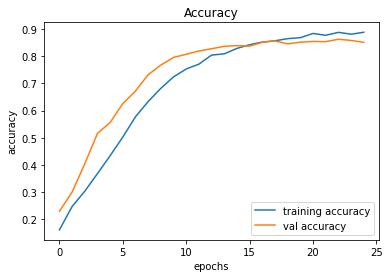

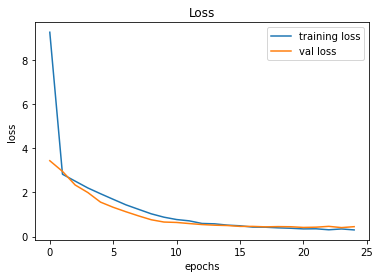

In [23]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
height = 150
width = 150

path = "lib/datasets/testout.jpg"

image = Image.open(path)
image = image.resize((width,height))
image = np.asarray(image)
print(image.shape)

test_image = image.astype('float64')

test_image -= np.mean(test_image, axis = 0)
image = test_image.reshape((1,150,150,3))
print(test_image.shape)
np.argmax(model.predict(image))

In [ ]:
model.save("lib/models/GermanModel/german")

In [ ]:
tmp = pd.DataFrame()
tmp["Label"] = lab
tmp["Encoding"] =list(range(len(lab)))
tmp.to_csv("lib/datasets/key.csv",index=False)

In [ ]:
pd.read_csv("lib/datasets/key.csv")